# Image Classification using MNIST dataset

## 0 - Import packages

In [121]:
# Import pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets

# Import Dataloader library
from torch.utils.data import DataLoader

# Ploting library
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Install and importing torchmetrics
!pip install torchmetrics
import torchmetrics

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import os for saving model
import os

## 1 - Getting MNIST dataset

In [101]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download images
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data", # where to download images
    train=False, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

## 2 - Explore datsets

In [102]:
# See all classes in dataset
classes = train_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [103]:
classes_id = train_data.class_to_idx
classes_id

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [104]:
# See labels and their size
train_data.targets, train_data.targets.shape

(tensor([9, 0, 0,  ..., 3, 0, 5]), torch.Size([60000]))

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

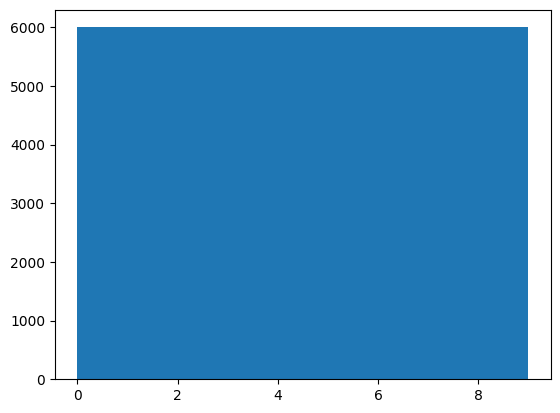

In [105]:
# Plot labels histogram
plt.hist(train_data.targets)

In [106]:
image, label = train_data[0]

In [107]:
print(f'Image shape: {image.shape}, Image data type: {image.dtype}')

Image shape: torch.Size([1, 28, 28]), Image data type: torch.float32


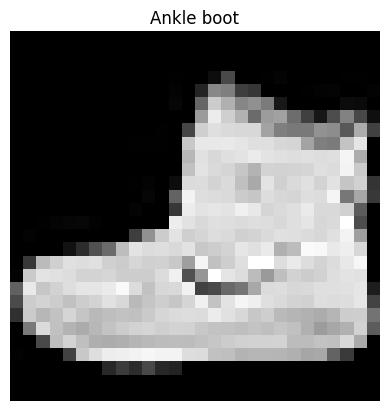

In [108]:
plt.title(classes[label])
plt.axis("off")
plt.imshow(image.squeeze(dim=0), cmap="gray")

## 3 - Prepare dataloader

In [109]:
BATCH_SIZE = 32

# Make dataloader for training data
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

# Make dataloader for testing data
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [110]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


## 4 - Settup device agnostic-code

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 5 - Make TinyVGG Model

Model architecture: https://poloclub.github.io/cnn-explainer/

In [112]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,        # Convolutional block
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),                                # ReLU activation function
      nn.Conv2d(in_channels=hidden_units,       # Convolutional block
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),                                # ReLU activation function
      nn.MaxPool2d(kernel_size=2)               # Max pool layer
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,       # Convolutional block
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),                                # ReLU activation function
      nn.Conv2d(in_channels=hidden_units,       # Convolutional block
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),                               # ReLU activation function
      nn.MaxPool2d(kernel_size=2)              # Max pool layer
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,  # we need this 7x7 because output from conv_block2 is torch.Size([1, 10, 7, 7])
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape} ")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape} ")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape} ")

    return x

In [113]:
model = TinyVGG(input_shape=1, # number of in channels in image (1 stand for gray picture)
                output_shape=len(classes),
                hidden_units=10).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [114]:
# Using to determine if everything works right
dummy_tensor = torch.rand(size=(1, 1, 28, 28))
tensor = model(image.unsqueeze(0).to(device))

### 5.1 - Setting up optimizer, loss function and evaulation metrics

In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
torchmetrics_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(classes)).to(device)

### 5.2 - Training and testing loop

In [116]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):

    # Put data on target device
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate training loss
    train_acc += accuracy_fn(target=y, preds=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc*100:.2f}%")


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      # Put data on target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss and accuracy (accumatively)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(target=y, preds=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")

In [117]:
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n ---------")
  train_step(model=model,
             data_loader=train_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             accuracy_fn=torchmetrics_accuracy,
             device=device)
  test_step(model=model,
             data_loader=train_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             accuracy_fn=torchmetrics_accuracy,
             device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ---------
Train loss: 0.88910 | Train acc: 67.09%

Test loss: 0.40223, Test acc: 85.85%

Epoch: 1
 ---------
Train loss: 0.38264 | Train acc: 86.19%

Test loss: 0.36437, Test acc: 87.24%

Epoch: 2
 ---------
Train loss: 0.34150 | Train acc: 87.79%

Test loss: 0.32170, Test acc: 88.16%



## 6 - Save model

In [128]:
MODEL_PATH = "models"

# Make 'models' directory if not exist
os.makedirs(MODEL_PATH, exist_ok=True)

# Save model
SAVING_PATH = MODEL_PATH + "/FashinoMNIST_TinyVGG.pth"
torch.save(obj=model.state_dict(), f=SAVING_PATH)